# Регрессия на основе гауссовских процессов

In [9]:
# Imports
import numpy as np
import numpy.polynomial.polynomial as plnml

import matplotlib
from matplotlib import cm # Colormaps
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.size'] = 12
sns.set_style('whitegrid')
np.random.seed(42)
#

---

## Условные распределения сечений
(*Гасников, стр. 71*)

Пусть дан нормальный случайный вектор $X$ с $n$ компонентами.
Пусть $X = (Y,Z)$, где $Y$ и $Z$ — два подвектора вектора $X$ с $n_1$ и $n_2$ компонентами, соответственно; $n = n_1 + n_2$.
Корреляционную матрицу вектора $X$ можно представить в виде
$$
    K =
    \left[
        \begin{array}{cc}
            K_{11} & K_{12} \\
            K_{21} & K_{22} \\
        \end{array}
    \right],
$$
где $K_{11}$ — корреляционная матрица вектора $Y$, $K_{22}$ — корреляционная матрица вектора $Z$, а матрицы $K_{12}$ и $K_{21} = K_{12}^T$ состоят из корреляций компонент вектора $Y$ и $Z$ (взаимные корреляционные матрицы).
Вектор математического ожидания $\mathrm{E}X = \mu$ также разбивается на два подвектора $\mathrm{E}Y = \mu_1$ и $\mathrm{E}Z = \mu_2$.

Условное распределение $Y$ при фиксированном $Z$ определяется нормальным законом с условным *математическим ожиданием*
$$
    \mathrm{E}(Y|Z) = \mu_1 + K_{12}K_{22}^{-1}(Z-\mu_2)
$$
и *условной корреляционной матрицей*
$$
  \mathrm{E} \left( (Y-\mathrm{E}(Y|Z))(Y-\mathrm{E}(Y|Z))^T \, |Z \right) = K_{11} - K_{12} K_{22}^{-1} K_{21}.
$$

Отметим, что условное математическое ожидание является линейной функцией от $Z$, а условная корреляционная матрица не зависит от $Z$.

---

Пусть задана выборка $\mathbf{S}=\left\{ x_i, u_i \right\}_{i=1}^n$ размера $n$, состоящая из точек $x_i \in \mathbb{X} \subseteq \mathbb{R}^d$ и значений целевой функции $u_i = u(x_i)$ в этих точках. Задача состоит в построении регрессионной модели $\tilde{u}(x)$ целевой функции $u(x)$ с использованием выборки $\mathbf{S}$.

Предположим, что $u(x)$ является реализацией гауссовского процесса. Для ясности и упрощения выкладок будем считать среднее значение гауссовского процесса равным нулю. Ковариоционная функция для гауссовского процесса, задающего $u(x)$ в точках $x$ и $x'$ имеет вид
$$
  \mathrm{cov}\left( u(x), u(x') \right) = k(x, x').
$$

Обозначим такие предположения как $u(x) \sim \mathcal{GP}\left( 0, c(x, x') \right)$. В таком случае совместное распределение вектора $u$ нормальное: $u \sim \mathcal{N}(0, K)$, где $C$ — ковариационная матрица вида $C = \left\{ c(x_i, x_j) \right\}_{i,j=1}^n$.

Для гауссовского процесса апостериорное распределение $u(x)$ при заданной выборке $\mathbf{S}$ в точке $x \in \mathbb{R}^d$ будет нормальным:
$$
  u(x)|\mathbf{S} \sim \mathcal{N}\left( \mu(x), \sigma^2(x) \right).  
$$

Выражения 

---

(*Зайцев, стр. 33*)

В регрессии на основе гауссовских процессов предполагается, что заданная выборка значений целевой функции является реализацией гауссовского процесса и ковариационная фнукция процесса зависит только от взаимного расположения точек в пространстве.
Апостериорное среднее гауссовского процесса в новой точке используется для прогноза целевой функции в этой точке, а апостериорная дисперсия используется в качестве оценки неопределённости прогноза.

Обычно предполагают, что ковариоционная функция гауссовского процесса лежит в параметрическом семействе.
Тогда задагние регрессионной модели эквивалентно выбору параметров ковариоционной функции. Для оценки параметров используют метод максимального правдоподобия и байесовские методы, особенно эффективные в случае наличия априорных знаний о модели.

In [3]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [4]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=None):
    X = X.ravel()
#     mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.figure(figsize=(8,5))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty,
                     color='grey', alpha=0.1, label='95% confidence interval')
    plt.plot(X, mu, 'k', label='Mean')
    if samples is not None:
        plt.plot(X, samples, '-', lw=1.0)
    if X_train is not None:
        plt.plot(X_train, Y_train, 'kx', mew=1.5)
    plt.legend()

# Set function

In [5]:
def get_noise(s, N):
    """generate noise"""
    return np.random.normal(scale=s, size=N)

def poly(x):
    """generate polynomial"""
    return plnml.polyval(x, poly_coeff)

def xsin(x):
    """generate polynomial"""
    return x * np.sin(x)

In [6]:
x_min, x_max = 0., 10.
noise_scale = 0.
poly_coeff = [0., 1.]

N_train = 6
N_test = 1001
N_pol = N_train

In [7]:
fun = poly

Test_points = [
    np.linspace(x_min, x_max, N_train),
    np.array([1., 2., 2.1, 3., 7., 8., 9.])
]

In [10]:
Case_num = 0

X_train = Test_points[Case_num]
Y_train = fun(X_train) + get_noise(noise_scale, N_train)

X_test = np.linspace(x_min, x_max, N_test)
# Fun = fun(X_test)

# X_train = np.append(X_train, [5., ])
# Y_train = np.append(Y_train, [-2., ])
# Y_train += 1.

# Gaussian process regression

In [69]:
l = 2.e-1*(x_max-x_min)
print('l =', l)

# Noiseless training data
X_train = X_train.reshape(-1,1)

# Apply the kernel function to training points
K = kernel(X_train, X_train, l)
L = np.linalg.cholesky(K + 1e-6*np.eye(len(X_train)))
print('L = ', L)

l = 2.0
L =  [[1.00000050e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.06530356e-01 7.95060958e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.35335216e-01 6.59629602e-01 7.39306545e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.11089910e-02 1.61745262e-01 6.74057686e-01 7.20667951e-01
  0.00000000e+00 0.00000000e+00]
 [3.35462460e-04 1.37165940e-02 1.70757330e-01 6.78825869e-01
  7.14037896e-01 0.00000000e+00]
 [3.72665131e-06 4.19090256e-04 1.46516326e-02 1.73993321e-01
  6.80512717e-01 7.11628358e-01]]


In [70]:
# Test data
X_test = X_test.reshape(-1,1)

# Compute the mean at test points
K_s = kernel(X_train, X_test, l)
Lk = np.linalg.solve(L, K_s)
Y_test = np.dot(Lk.T, np.linalg.solve(L, Y_train)).reshape((-1,))

In [71]:
# Compute covariance
K_ss = kernel(X_test, X_test, l)
Sigma = K_ss - np.dot(Lk.T, Lk)

# Generate samples from the posterior at test points
N_gp = 1
Ls = np.linalg.cholesky(Sigma + 1e-6*np.eye(N_test))
gp = Y_test.reshape(-1,1) + np.dot(Ls, np.random.normal(size=(N_test,N_gp)))

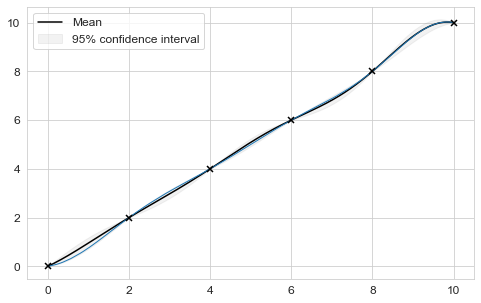

In [72]:
# Draw samples from the posterior
plot_gp(Y_test, Sigma, X_test, X_train, Y_train, samples=gp)

## Литература

1. Зайцев А.А. Методы построения регрессионных моделей разнородных источников данных для индустриальной инженерии // PhD Thesis. ИППИ РАН, 2017. 148 с.